This notebook generates Supplementary Figures 5-10 in the Sei framework manuscript, showing histone mark enrichment across cell types using the Roadmap Epigenomic chromatin profile tracks. These supplementary figures are used to interpret the different sequence classes. 

In [1]:
from collections import defaultdict
import glob
import os

import h5py
import numpy as np
import pandas as pd

In [2]:
import matplotlib as mpl
from matplotlib.colors import SymLogNorm
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-white')

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [3]:
RESOURCES_DIR = '../resources'
DATA_DIR = './data'
SEI_DIR = './sei_data'
FIGS_DIR = './figures'

In [4]:
SC_NAMES_FILE = os.path.join(RESOURCES_DIR, 'cnames.tsv')
df = pd.read_csv(SC_NAMES_FILE, sep='\t')
df.head()
MAPPING = {}
for row in df.itertuples():
    MAPPING[row.index] = '{0} {1}'.format(row.ID, row.name)

In [5]:
HIST_CA_MAPPING = {
    'H3K4me3': 'Promoter',
    'H3K4me1': 'Enhancer',
    'H4K20me1': 'Transcription',
    'H3K27ac': 'Enhancer',
    'H3K36me3': 'Transcription',
    'H3K27me3': 'Polycomb',
    'H3K4me2': 'Promoter',
    'H3K9me3': 'Heterochromatin',
    'H3K79me2': 'Transcription',
    'H3K9ac': 'Biv Promoters, Active Enh',
    'DNase': 'Chromatin Acc'
}

In [6]:
def get_track_enrichment(pwd):
    rowlabels = []
    data = []
    for fp in glob.glob(pwd + '/*bed.npy'):
        data.append(np.load(fp))
        fn = os.path.basename(fp)
        rowlabels.append(fn.split('.')[0])
    data = np.vstack(data)
    return data, rowlabels

regulatory_categories = set()
mark_infodict = defaultdict(dict)
for mark, desc in HIST_CA_MAPPING.items():
    pwd = os.path.join(
        SEI_DIR, 'roadmap_enrichments', '{0}_enrichment'.format(mark))
    if not os.path.exists(pwd):
        continue
    print(mark, desc)
    regulatory_categories.add(desc)
    mark_infodict[mark]['data'], mark_infodict[mark]['rowlabels'] = \
        get_track_enrichment(pwd)

H3K4me3 Promoter
H3K4me1 Enhancer
H3K27ac Enhancer
H3K36me3 Transcription
H3K27me3 Polycomb
H3K9me3 Heterochromatin
DNase Chromatin Acc


In [7]:
def plot_enhancers(rowlabels, colnames, data, savefig, title=''):
    cmap_data = data[:]
    cmap_data[data == -np.inf] = 1e-300
    df = pd.DataFrame(cmap_data)
    df.rename(index={i: r.replace('_', ' ') 
                     for (i, r) in enumerate(rowlabels)}, inplace=True)
    df.columns = colnames
    sns.set(font_scale=2)
    cm = sns.clustermap(df,
                        figsize=(50, int(0.4 * len(rowlabels))),
                        linewidths=0.08, xticklabels=1, yticklabels=1, 
                        cmap='RdBu_r', center=0, vmin=-16, vmax=16, 
                        mask=cmap_data == 1e-300,
                        norm=SymLogNorm(linthresh=2, linscale=1),
                        row_cluster=True, col_cluster=False,
                        cbar_kws={'shrink': 0.01, 'aspect': 1})
    cm.fig.suptitle(title, y=0.89)
    plt.savefig(
        os.path.join(FIGS_DIR, savefig + '.pdf'), dpi=300) 

/mnt/home/kchen/anaconda3/envs/sei-manu/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  


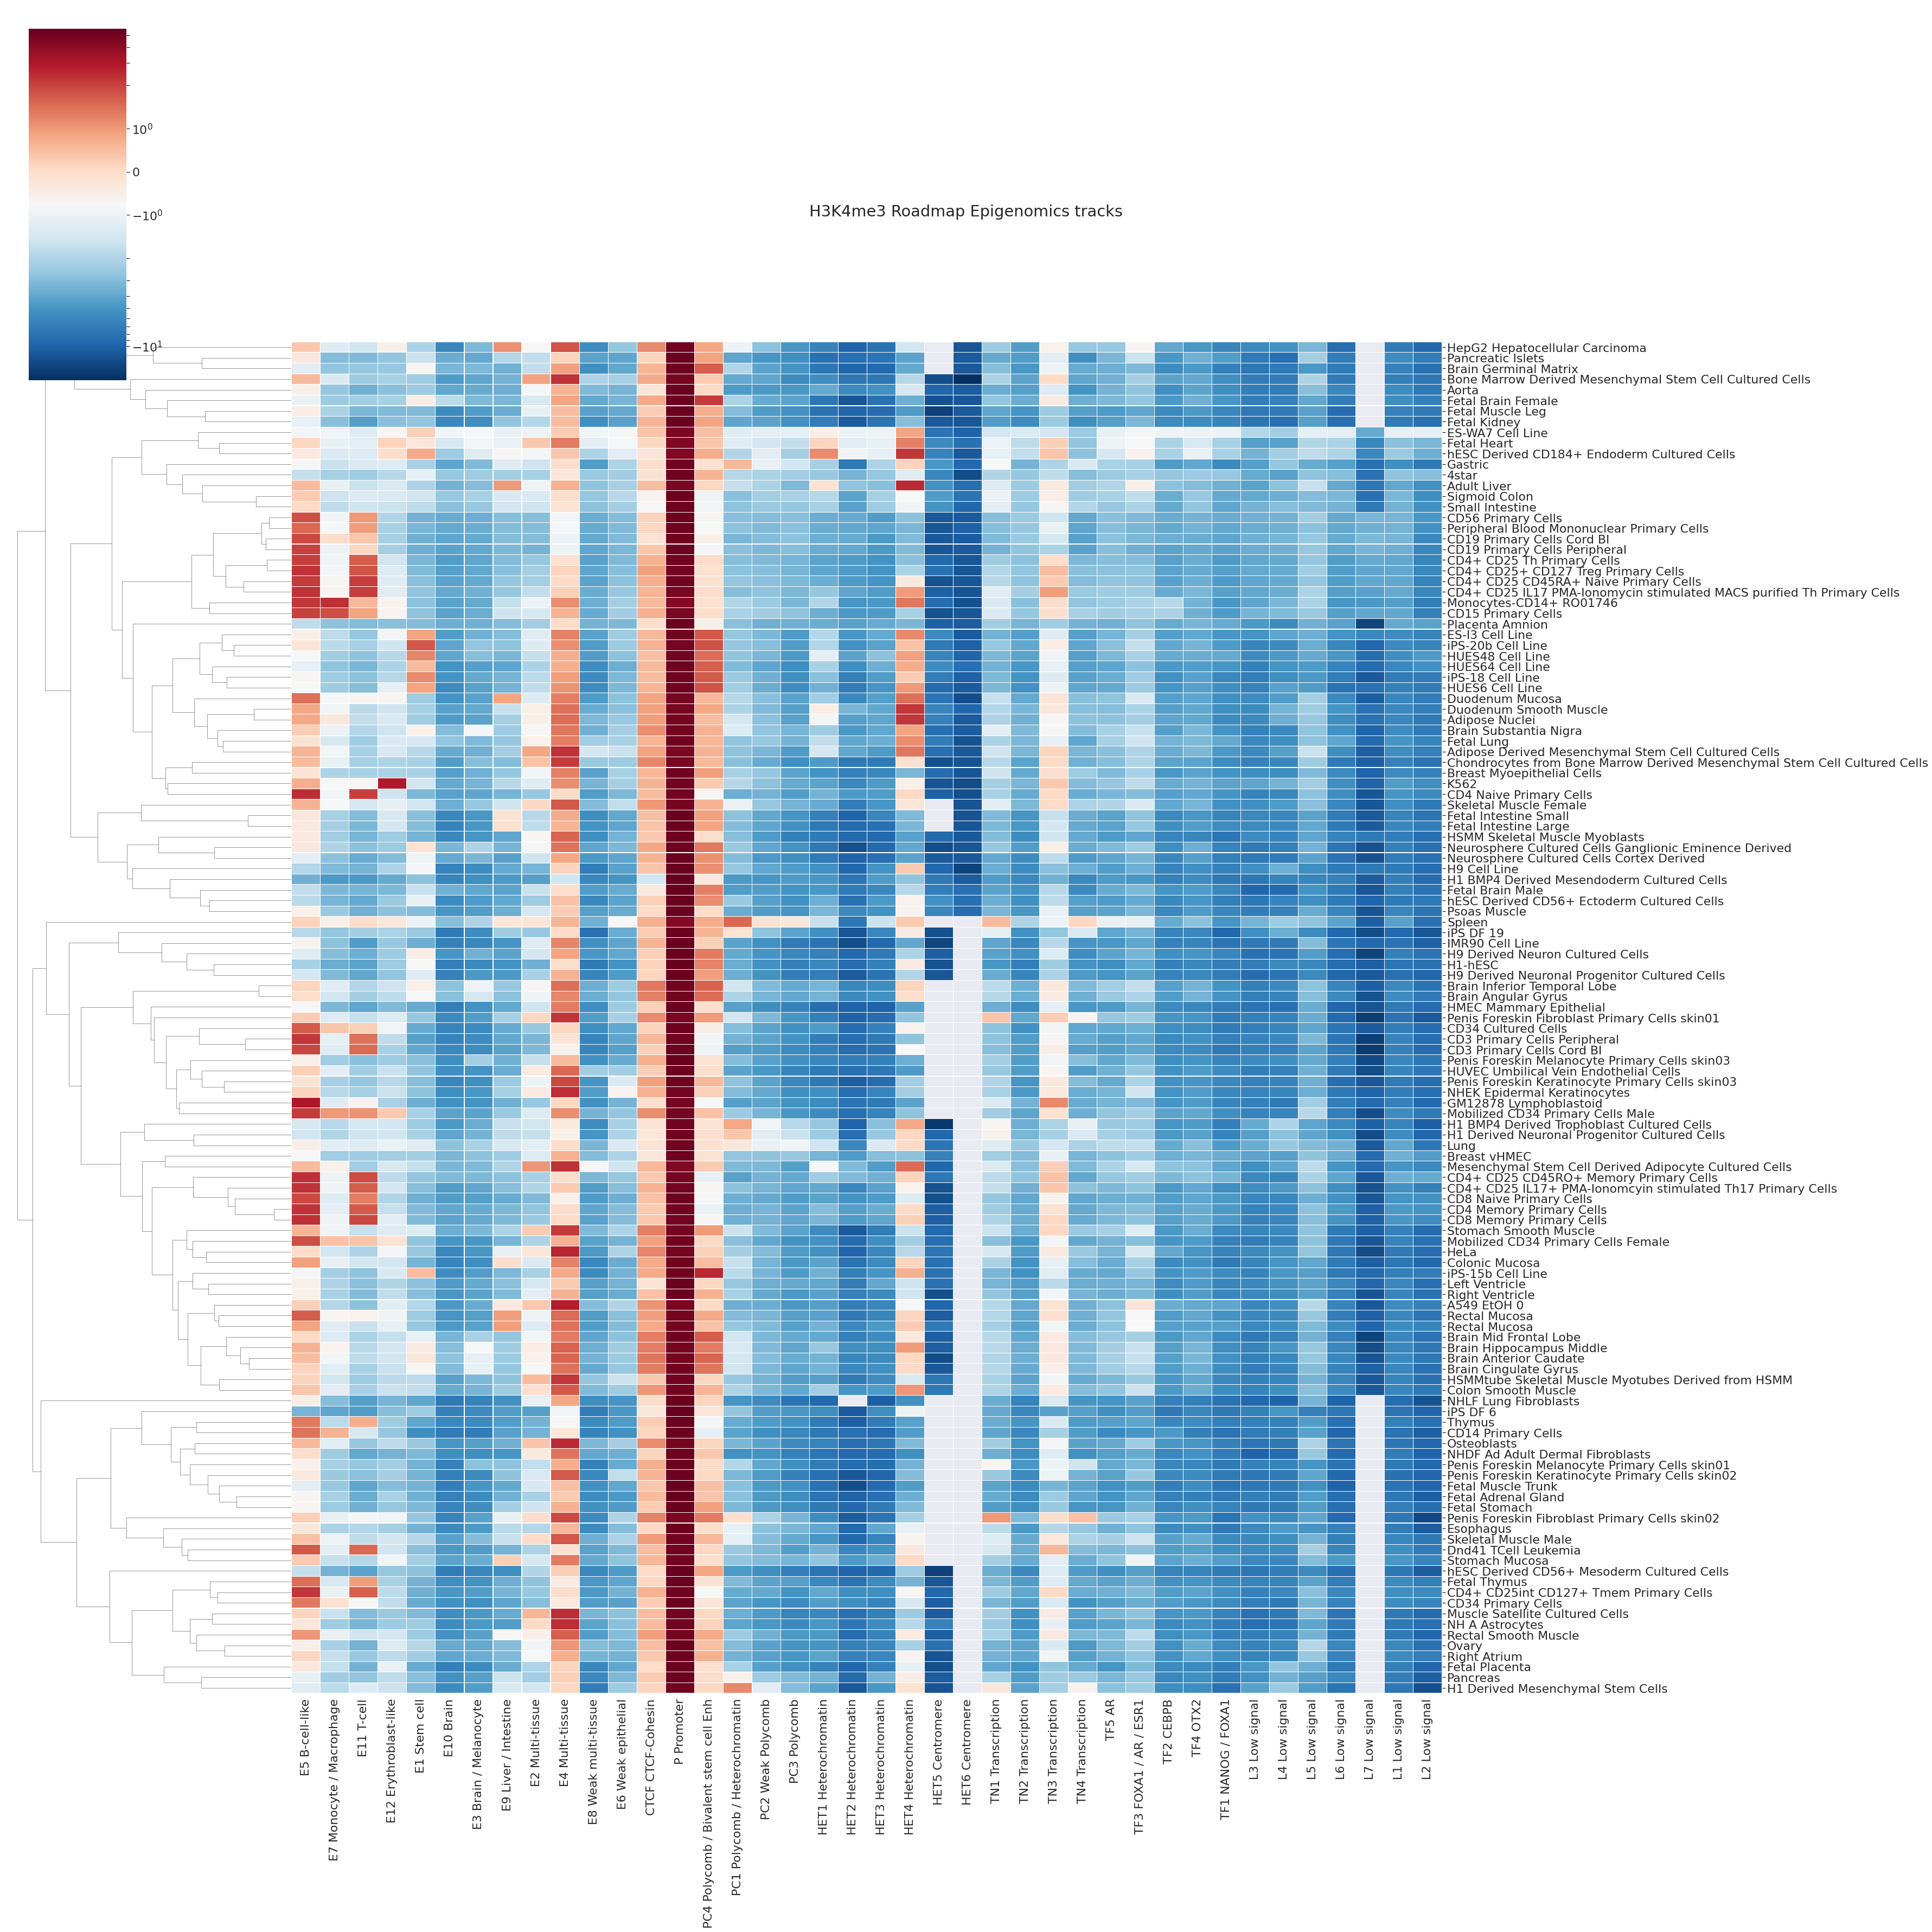

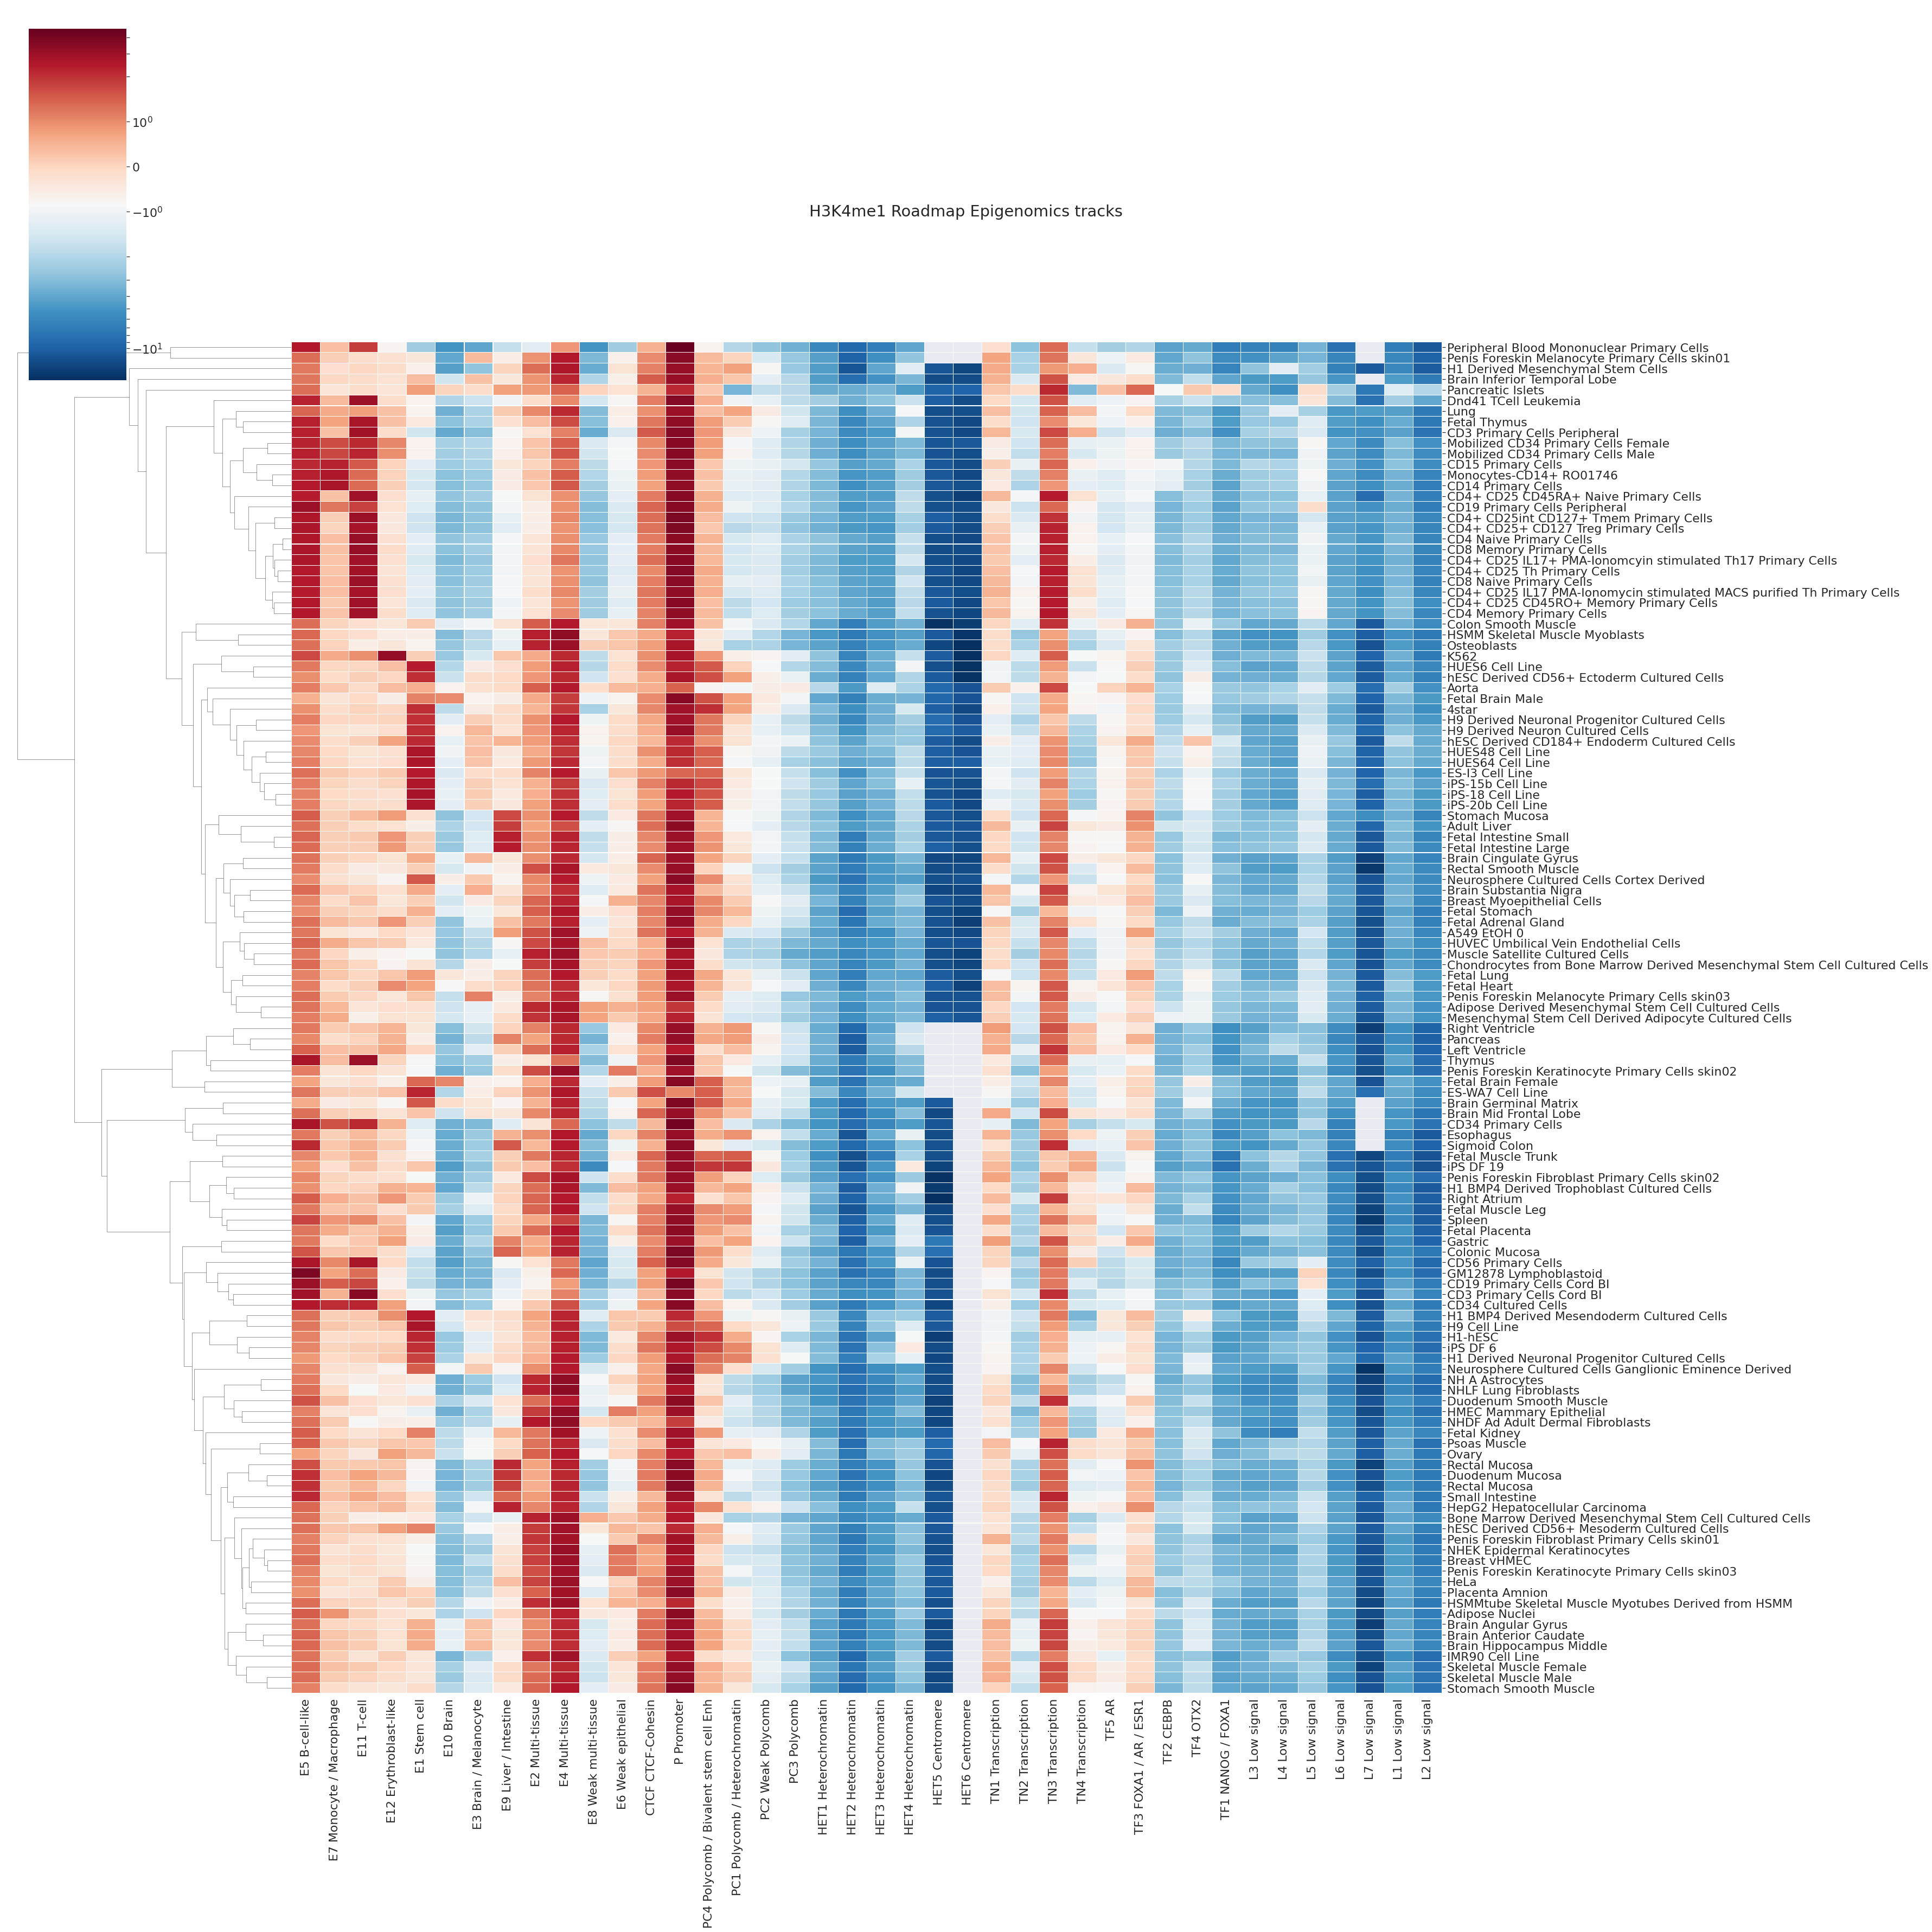

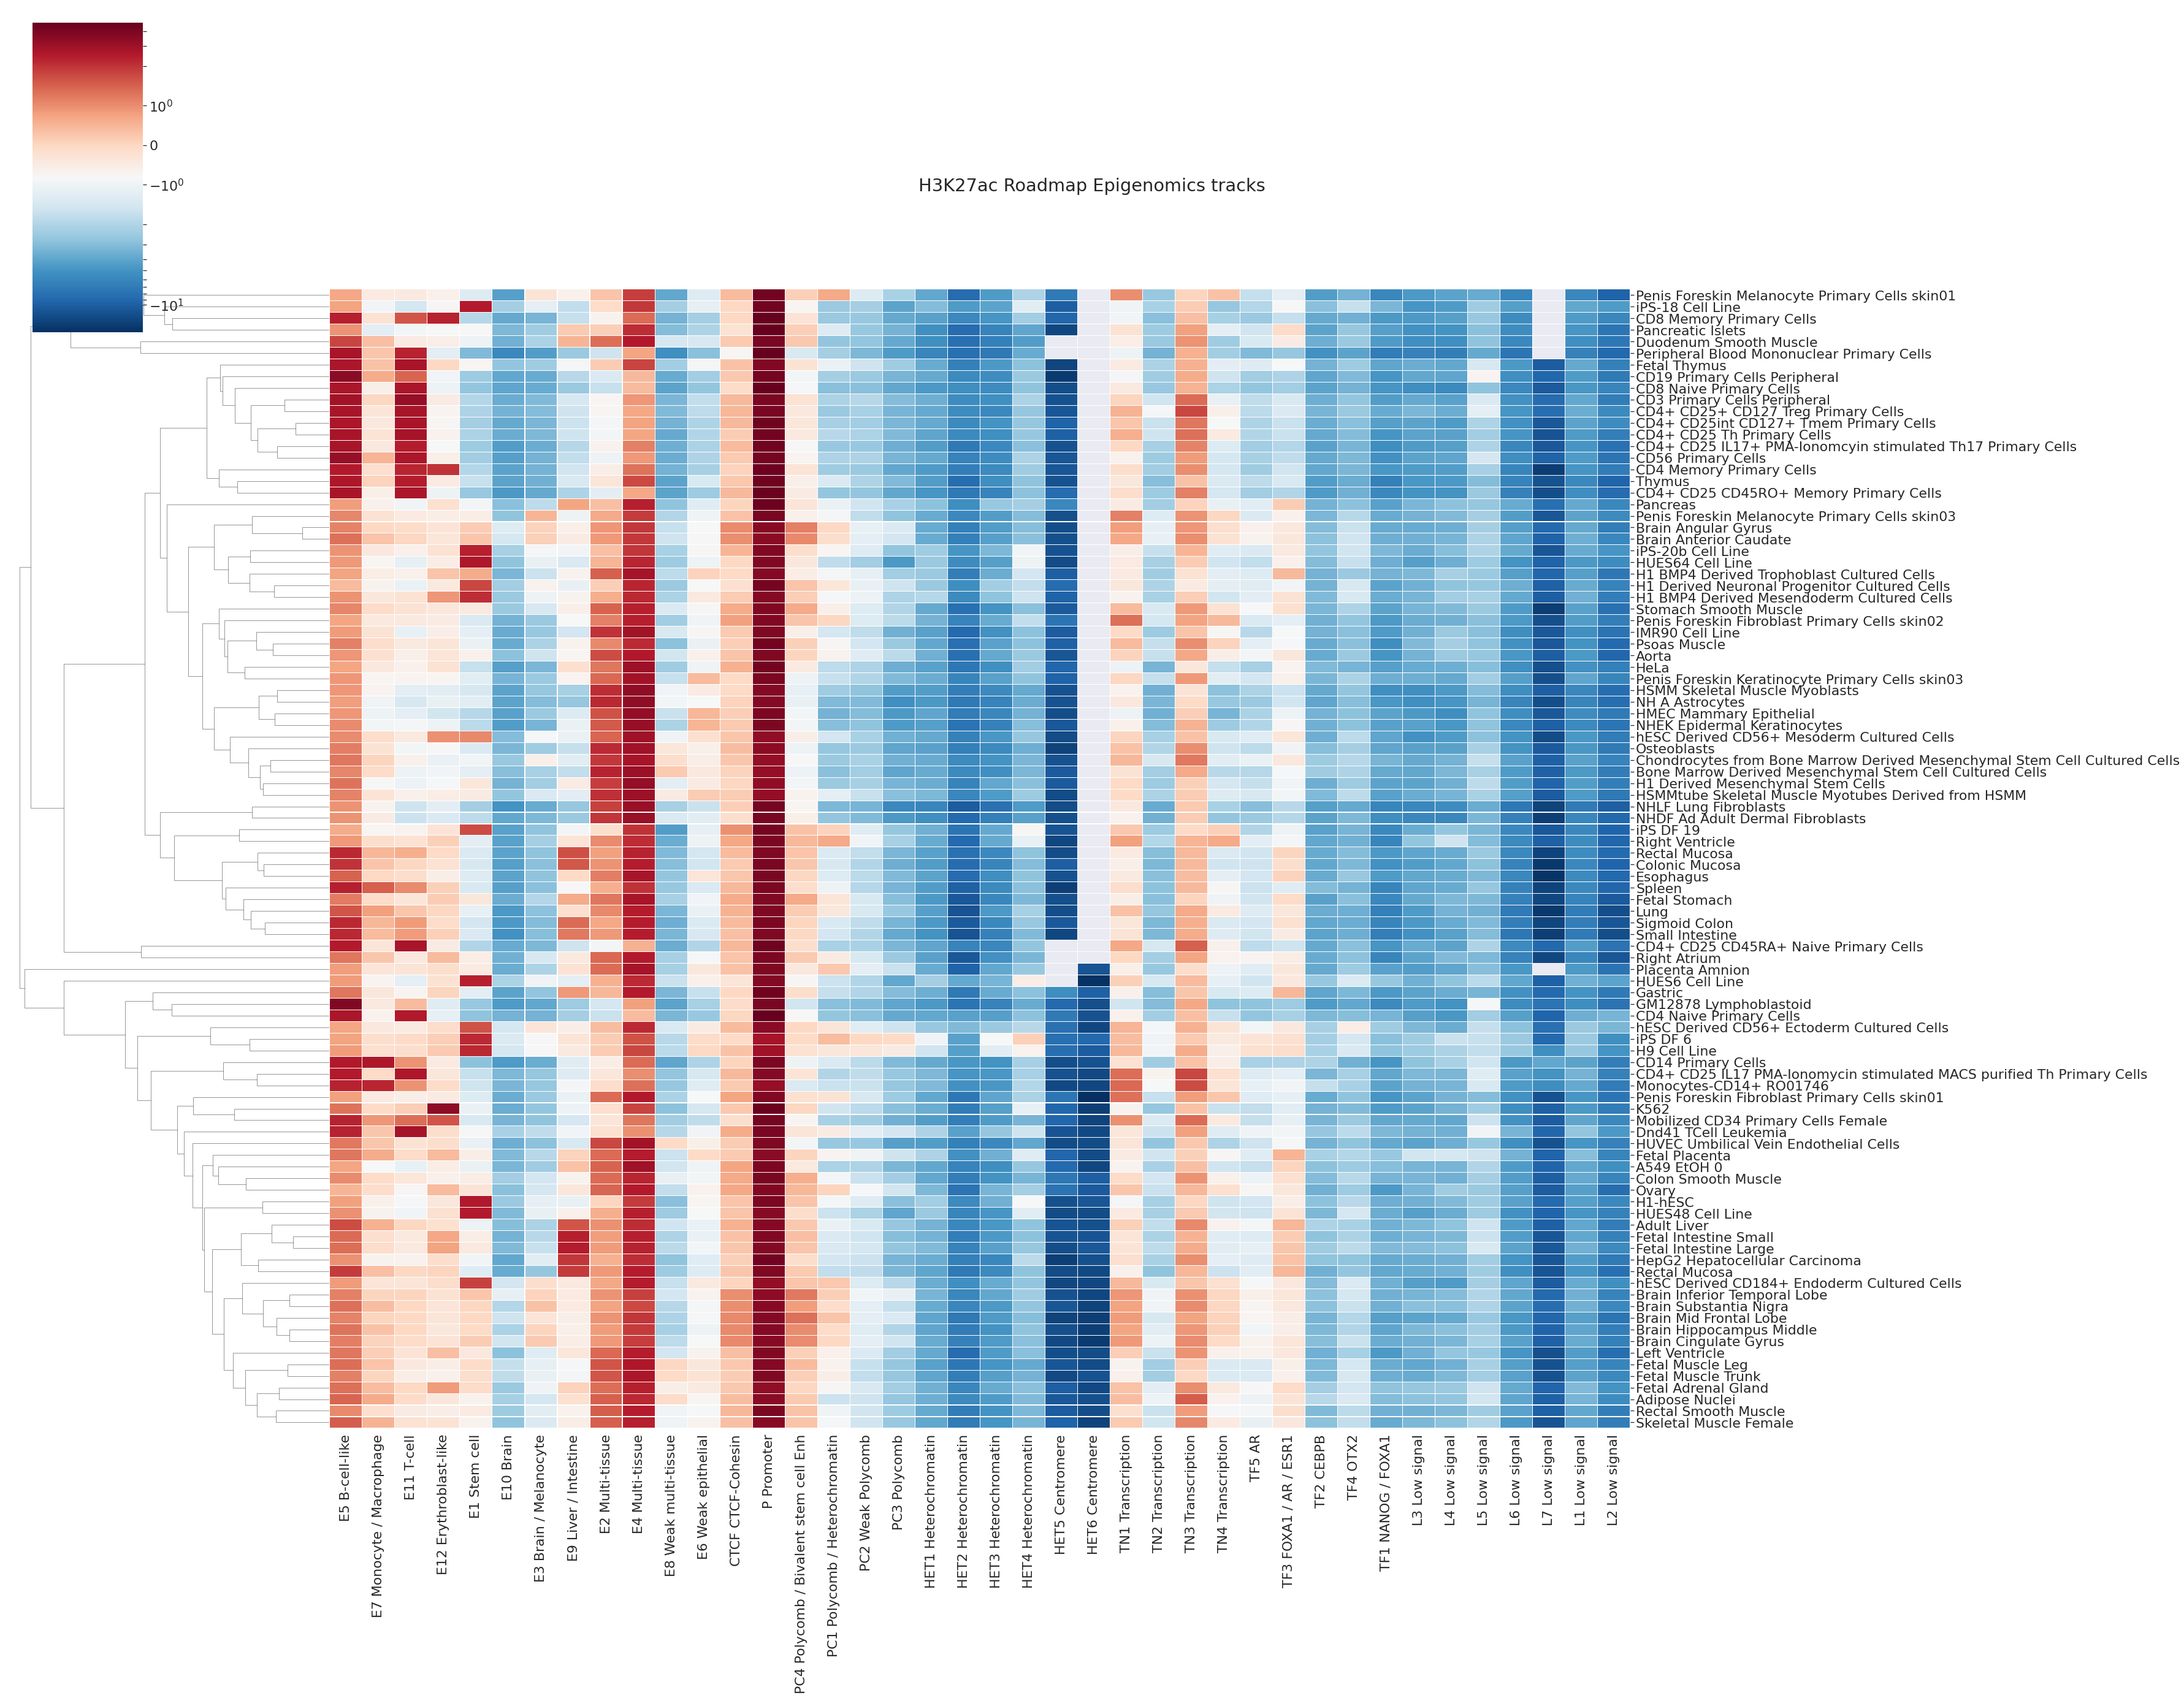

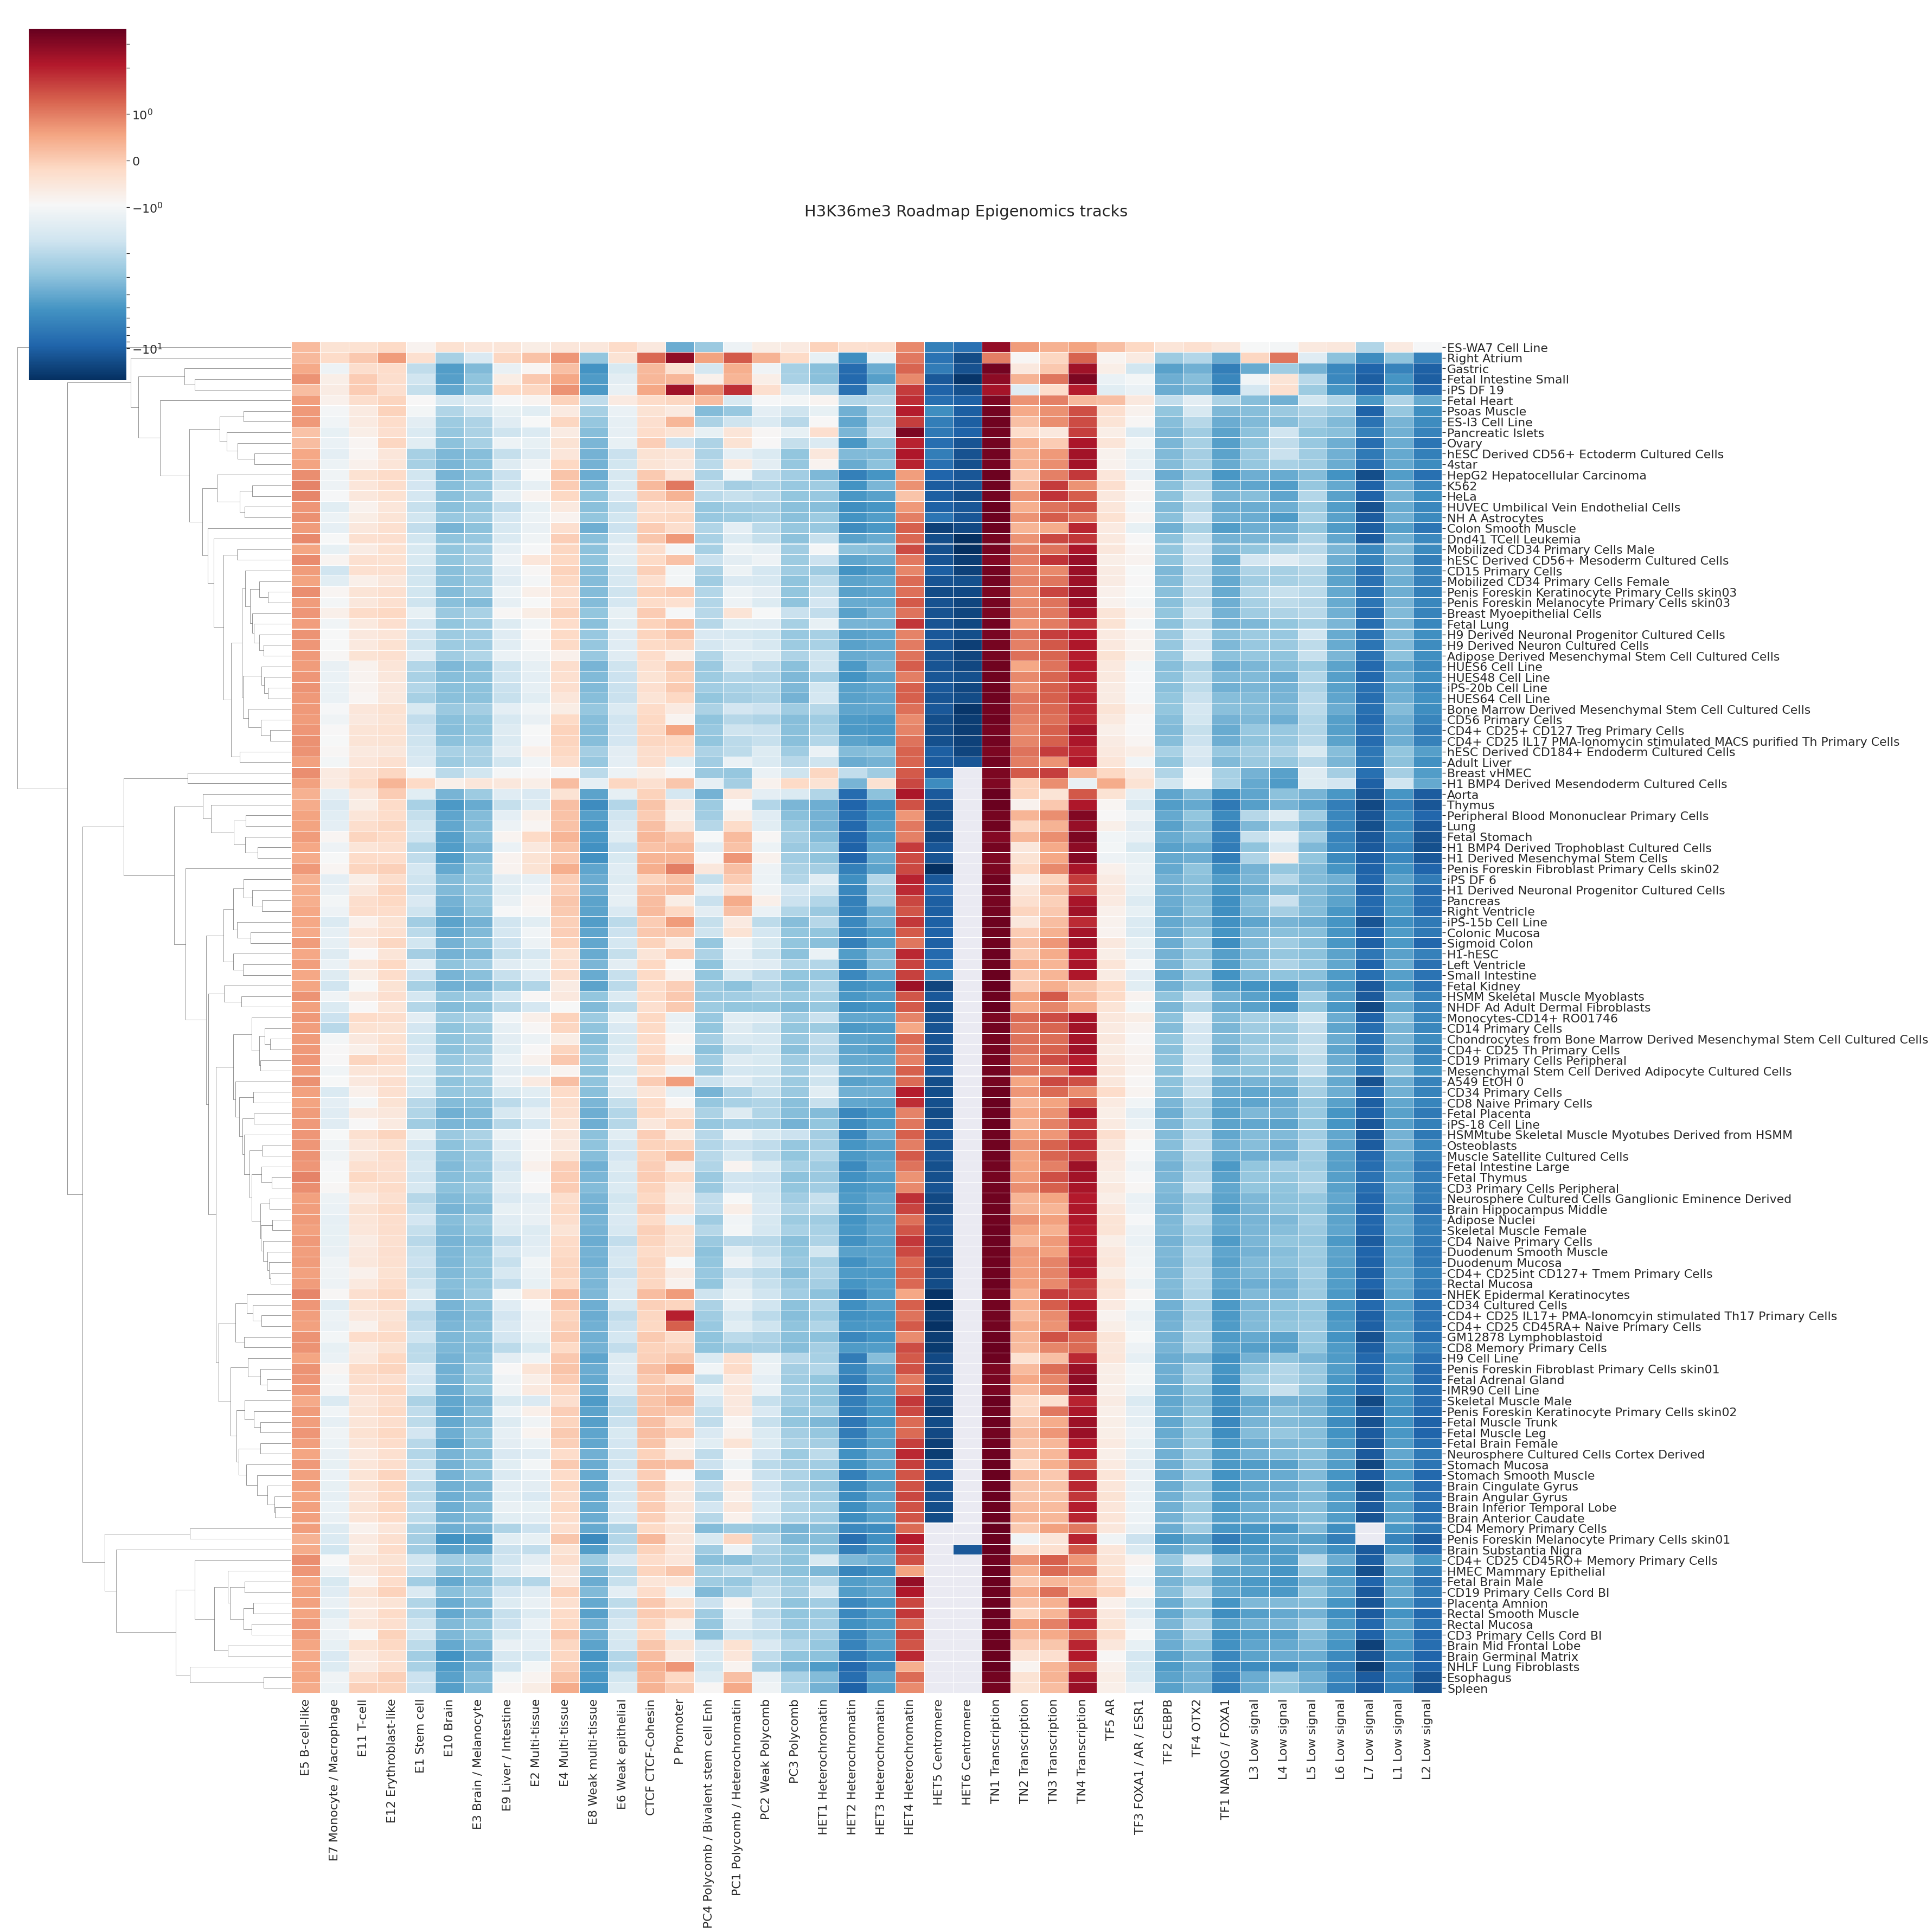

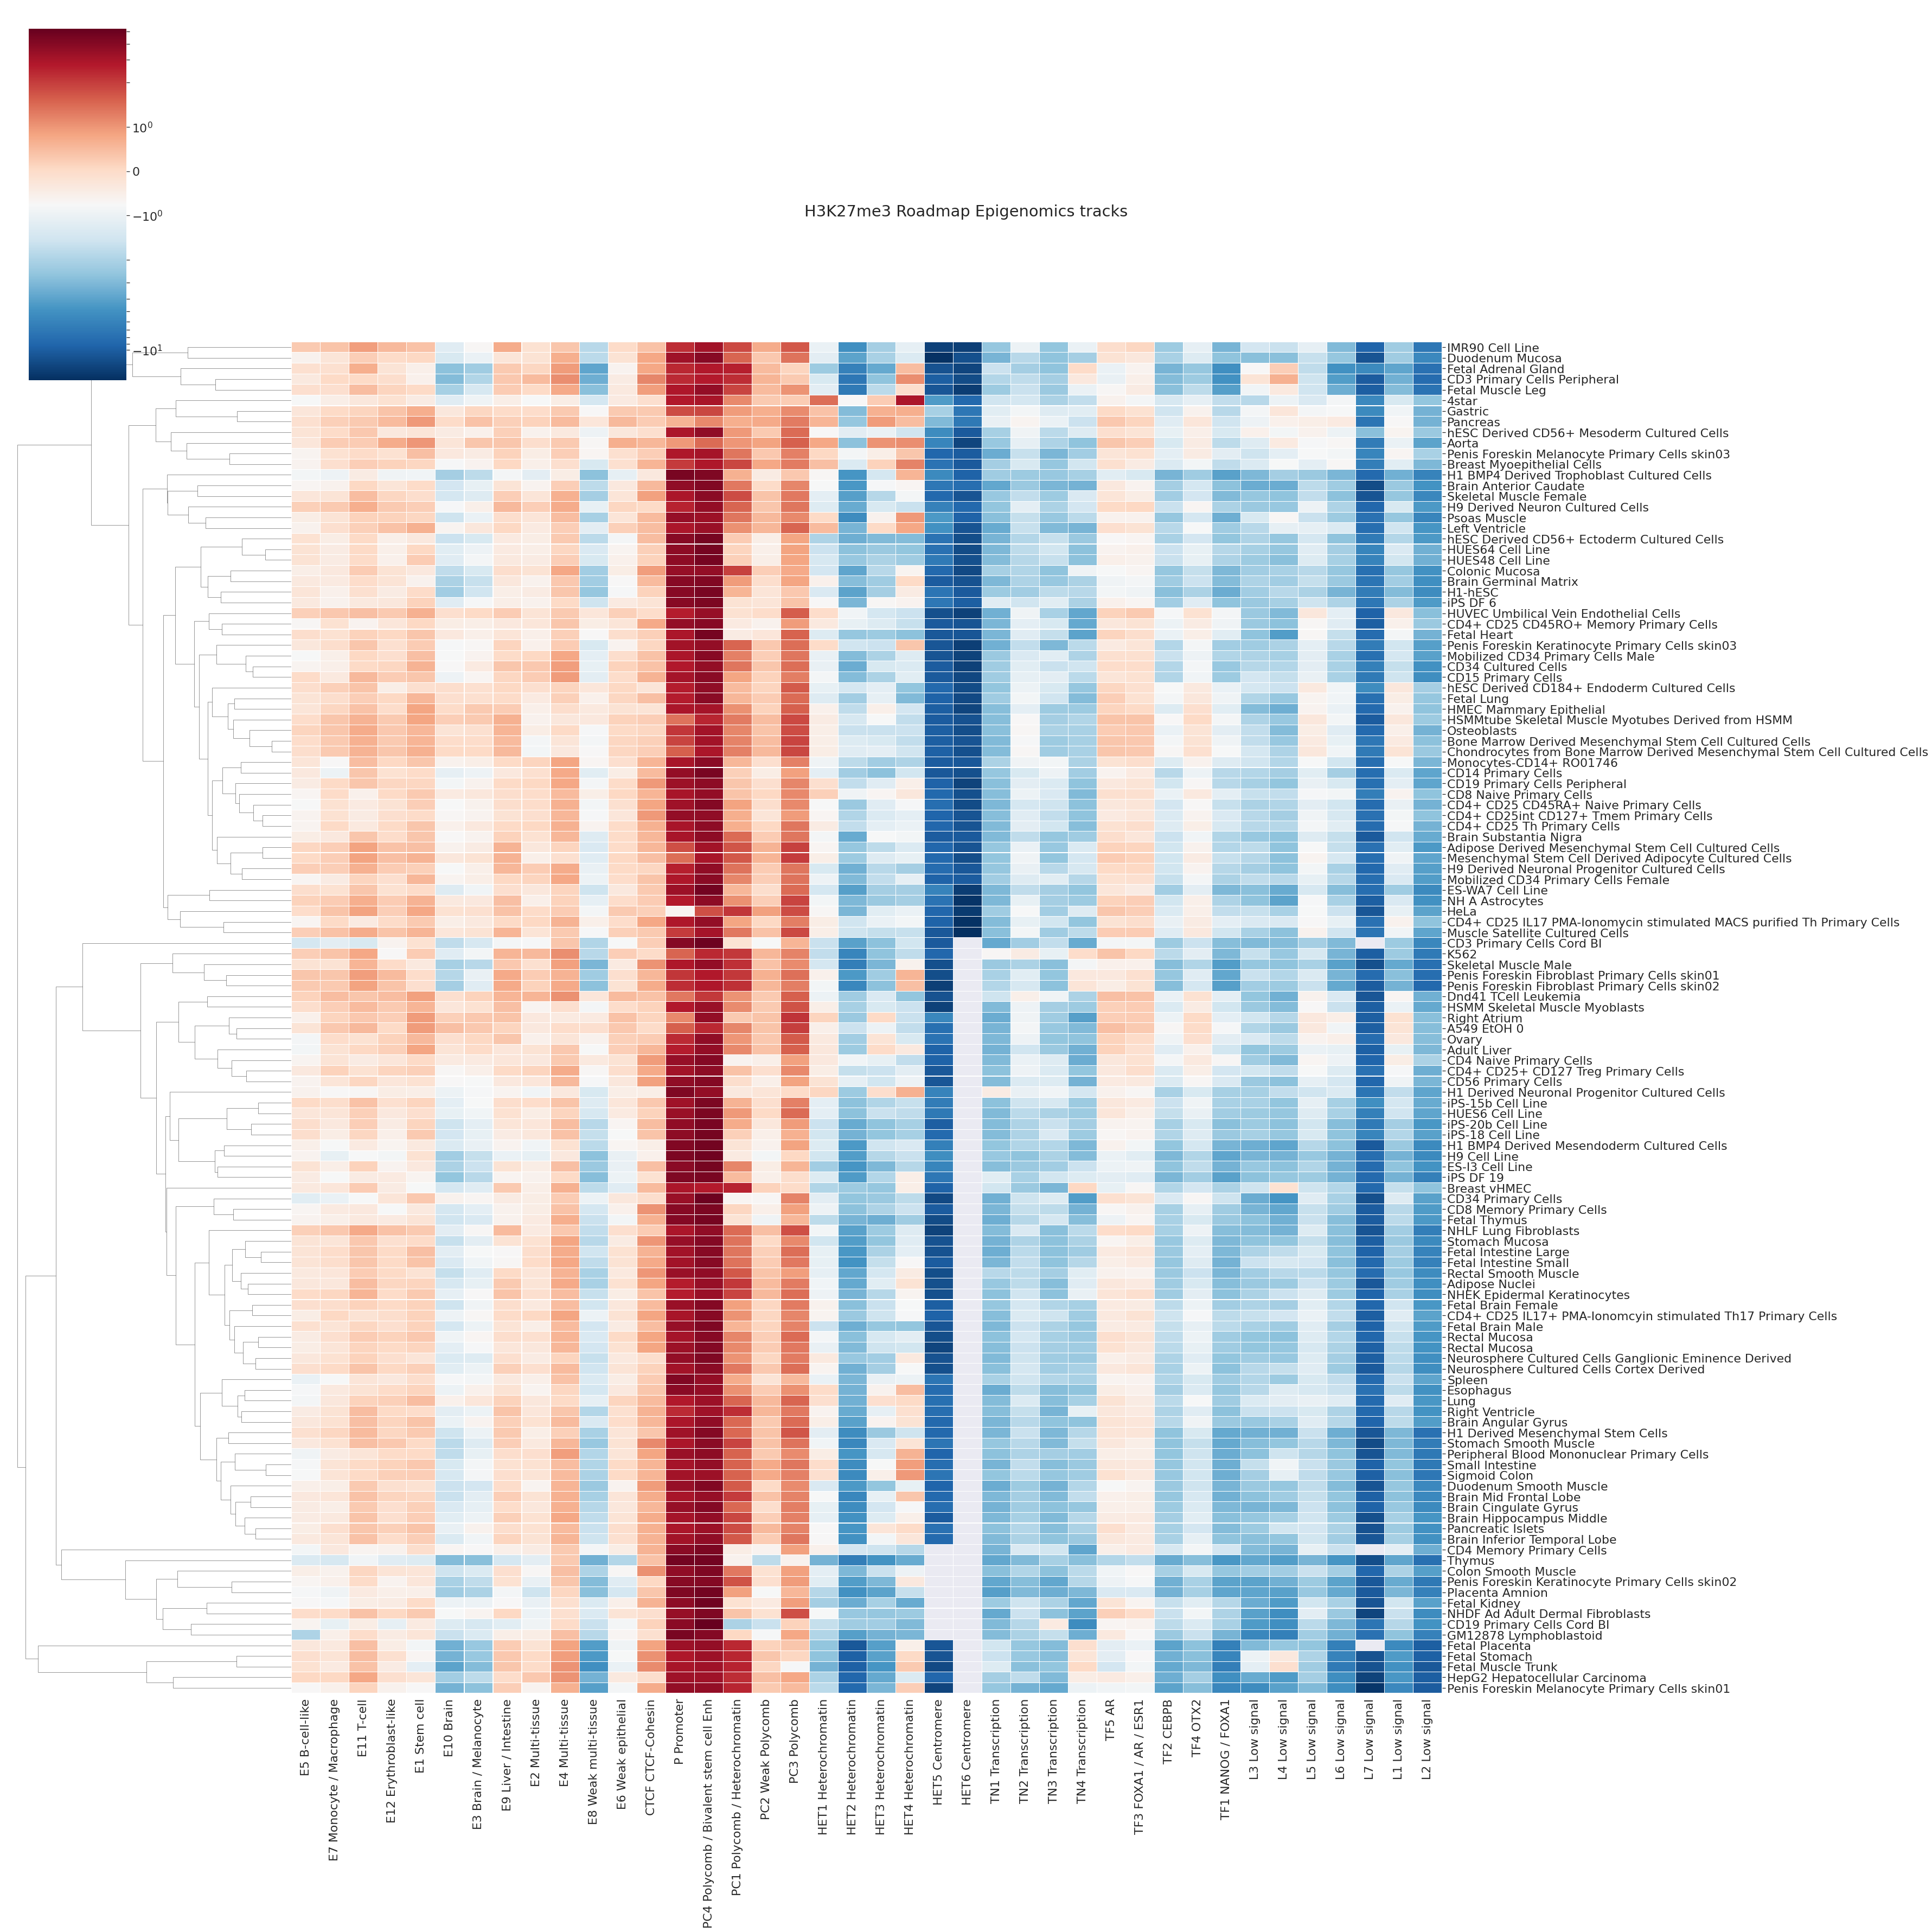

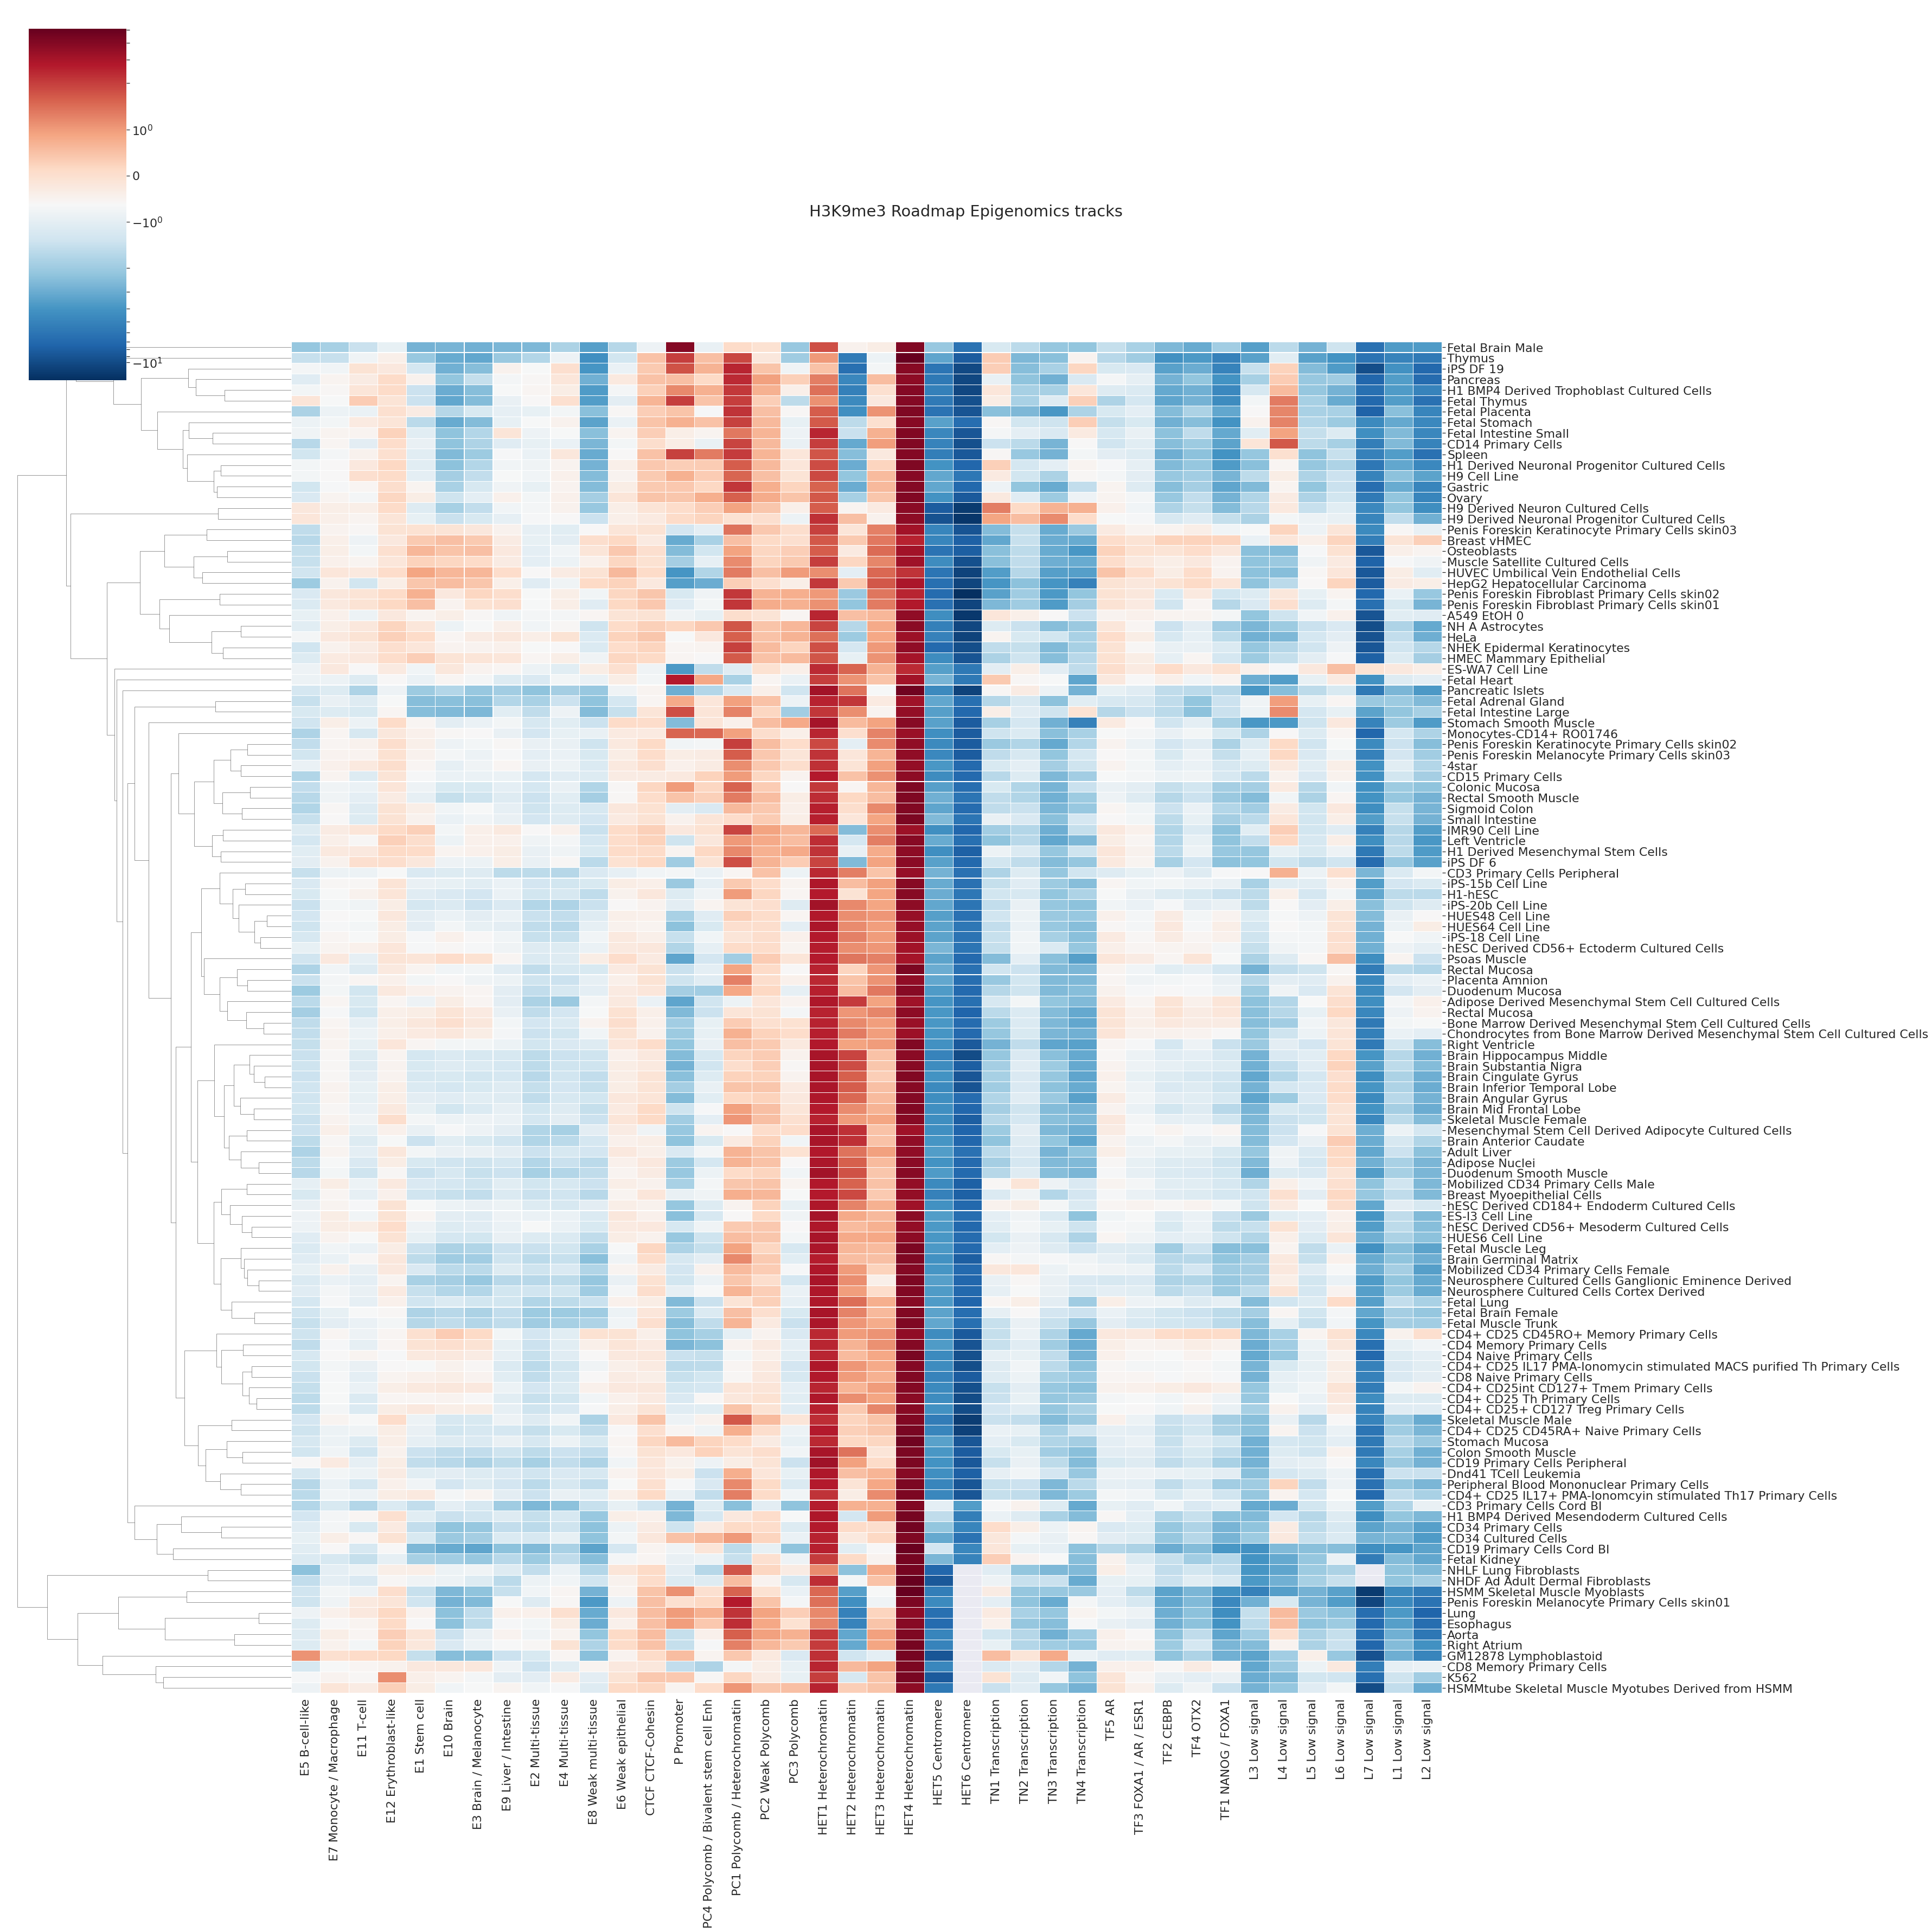

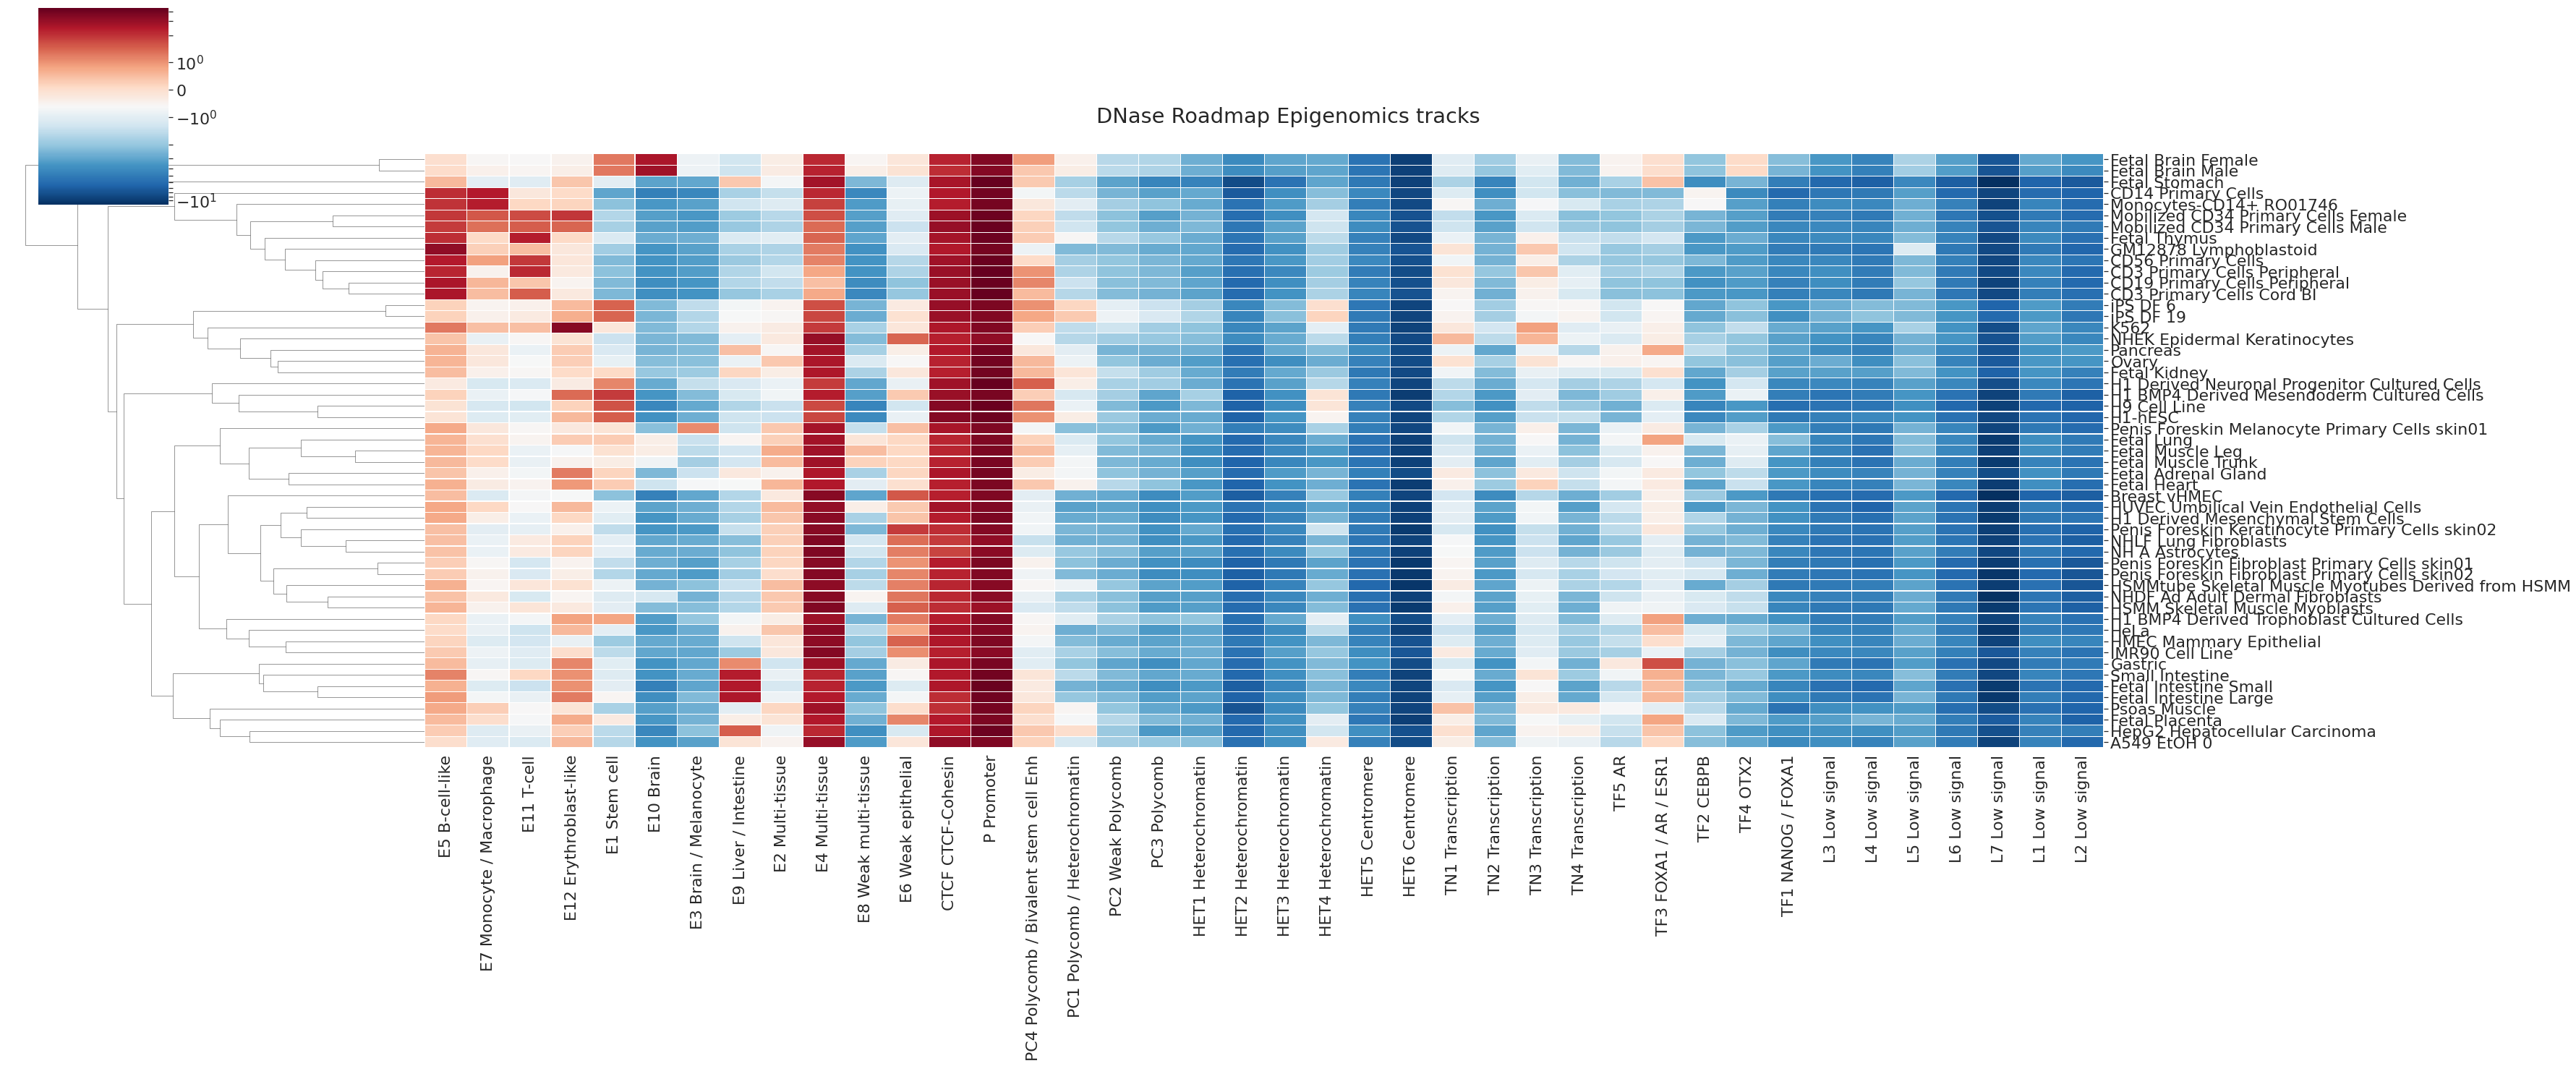

In [8]:
col_ordering = list(MAPPING.keys()) 
col_names = list(MAPPING.values()) 
for mark, infodict in mark_infodict.items():
    plot_enhancers(
        infodict['rowlabels'], col_names, infodict['data'][:, col_ordering], mark,
        title="{0} Roadmap Epigenomics tracks".format(mark))